In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
# Load the cleaned datasets
reviews = pd.read_parquet('data/review_Cell_Phones_and_Accessories.parquet')
metadata = pd.read_parquet('data/metadata_Cell_Phones_and_Accessories.parquet')

# Merge the datasets on 'asin' and 'parent_asin'
merged_data = pd.merge(reviews, metadata, on=['parent_asin'], how='inner')

c:\Users\LENOVO\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


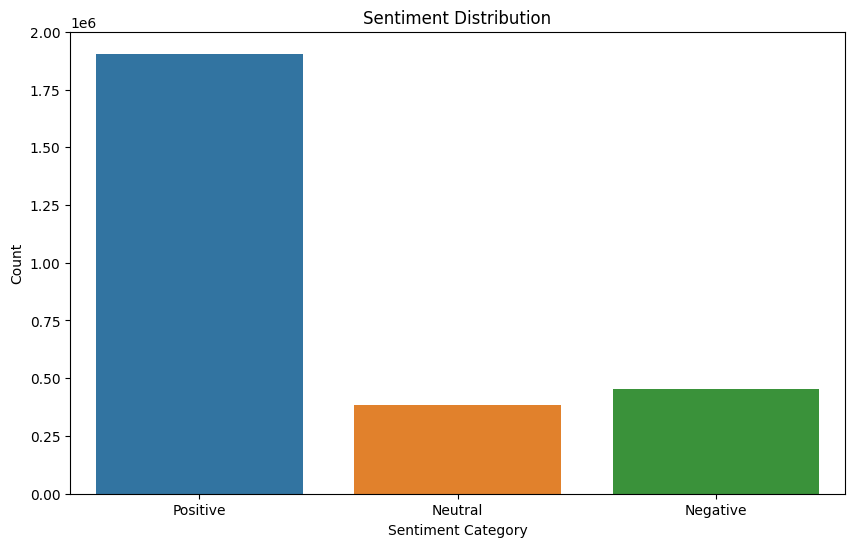

In [4]:
# Sentiment Analysis
sid = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    """Analyze sentiment of the given text."""
    scores = sid.polarity_scores(text)
    return scores['compound']

# Apply sentiment analysis to the review text
merged_data['sentiment_score'] = merged_data['text'].apply(analyze_sentiment)

# Categorize sentiment
merged_data['sentiment_category'] = pd.cut(
    merged_data['sentiment_score'], 
    bins=[-1, -0.1, 0.1, 1], 
    labels=['Negative', 'Neutral', 'Positive']
)

# Exploratory Data Analysis (EDA)
plt.figure(figsize=(10, 6))
sns.countplot(data=merged_data, x='sentiment_category', order=['Positive', 'Neutral', 'Negative'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.show()

# Visualize sentiment distribution for the top 10 products with most reviews

c:\Users\LENOVO\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\LENOVO\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\LENOVO\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning

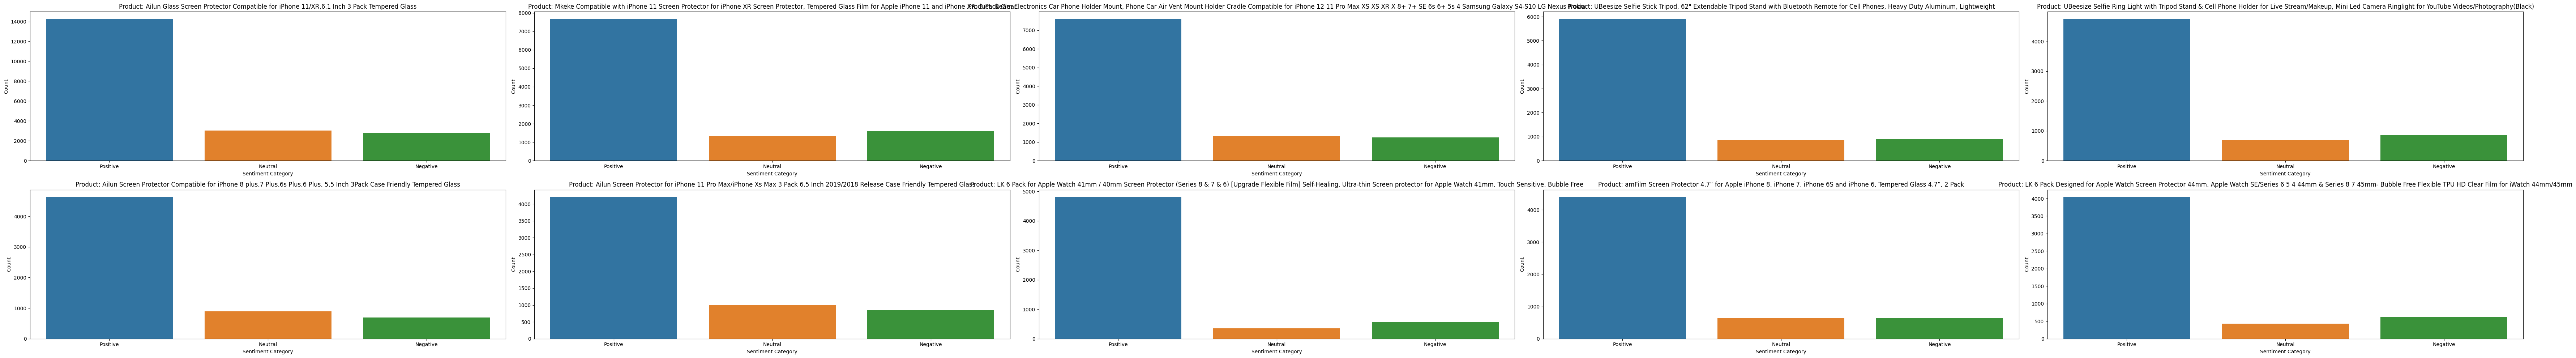

In [22]:
# Group data by 'parent_asin'
grouped_data = merged_data.groupby('parent_asin')

# Function to plot sentiment distribution for multiple products using subplots
def plot_sentiment_distributions(products, metadata, n_per_row=5):
    n_products = len(products)
    n_rows = (n_products // n_per_row) + (n_products % n_per_row > 0)
    
    fig, axes = plt.subplots(n_rows, n_per_row, figsize=(70, n_rows * 5))
    axes = axes.flatten()  # Flatten the axes array for easy iteration
    
    for i, product_asin in enumerate(products):
        product_data = merged_data[merged_data['parent_asin'] == product_asin]
        product_title = metadata.loc[metadata['parent_asin'] == product_asin, 'title'].values[0] if not metadata.empty else product_asin
        
        sns.countplot(data=product_data, x='sentiment_category', order=['Positive', 'Neutral', 'Negative'], ax=axes[i])
        axes[i].set_title(f'Product: {product_title}')
        axes[i].set_xlabel('Sentiment Category')
        axes[i].set_ylabel('Count')
    
    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

top_products = merged_data['parent_asin'].value_counts().head(10).index
plot_sentiment_distributions(top_products, metadata)



# Word Cloud for Positive and Negative Reviews

[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


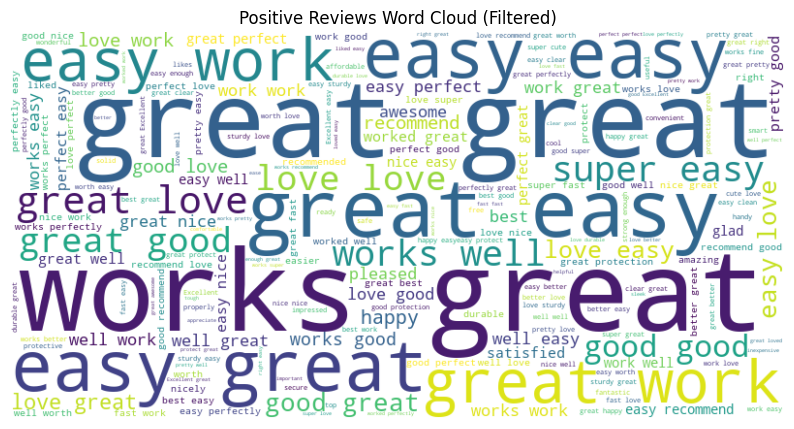

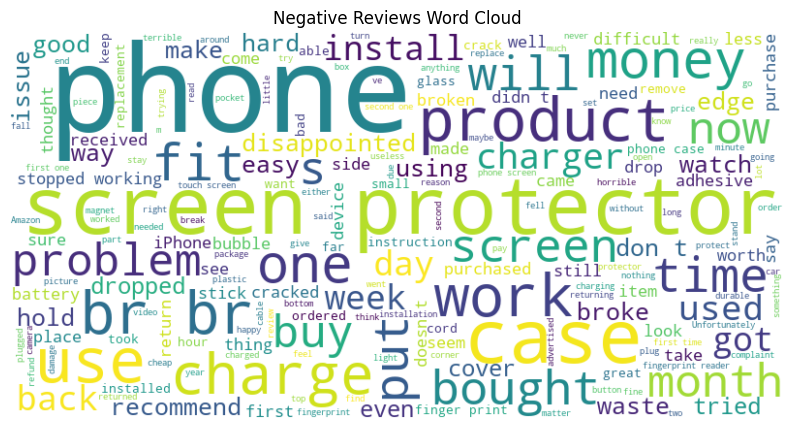

In [23]:
# Download the opinion lexicon
download('opinion_lexicon')

# Get a list of positive words from the lexicon
positive_words_set = set(opinion_lexicon.positive())

def filter_positive_words(text):
    """Filter only positive words from the text."""
    words = text.split()
    return " ".join(word for word in words if word.lower() in positive_words_set)

def plot_wordcloud_filtered(data, sentiment_category, filter_positive=False):
    text = " ".join(data[data['sentiment_category'] == sentiment_category]['text'].fillna(""))
    if filter_positive:
        text = filter_positive_words(text)  # Filter for positive words
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'{sentiment_category} Reviews Word Cloud (Filtered)' if filter_positive else f'{sentiment_category} Reviews Word Cloud')
    plt.show()

# Plot word clouds
plot_wordcloud_filtered(merged_data, 'Positive', filter_positive=True)  # Positive words only
plot_wordcloud_filtered(merged_data, 'Negative')  # Full negative reviews


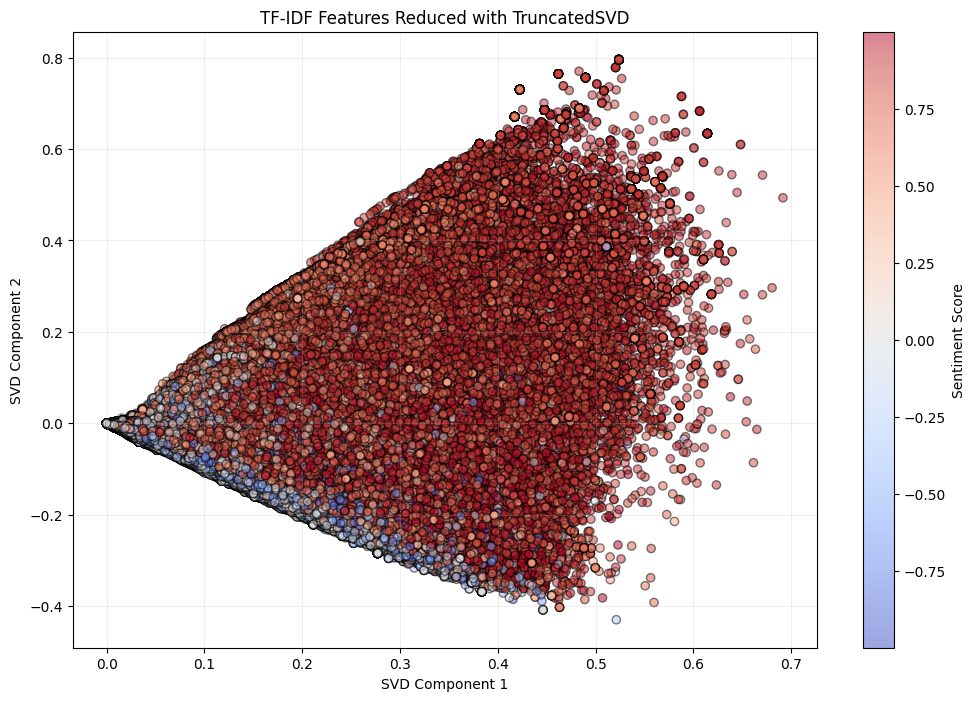

In [12]:
from sklearn.decomposition import TruncatedSVD

# Dimensionality Reduction with TruncatedSVD
svd = TruncatedSVD(n_components=2, random_state=42)
reduced_tfidf = svd.fit_transform(tfidf_matrix)

# Scatter Plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    reduced_tfidf[:, 0], reduced_tfidf[:, 1],
    c=merged_data['sentiment_score'], cmap='coolwarm', alpha=0.5, edgecolors='k'
)
plt.colorbar(scatter, label='Sentiment Score')
plt.title('TF-IDF Features Reduced with TruncatedSVD')
plt.xlabel('SVD Component 1')
plt.ylabel('SVD Component 2')
plt.grid(alpha=0.2)
plt.show()


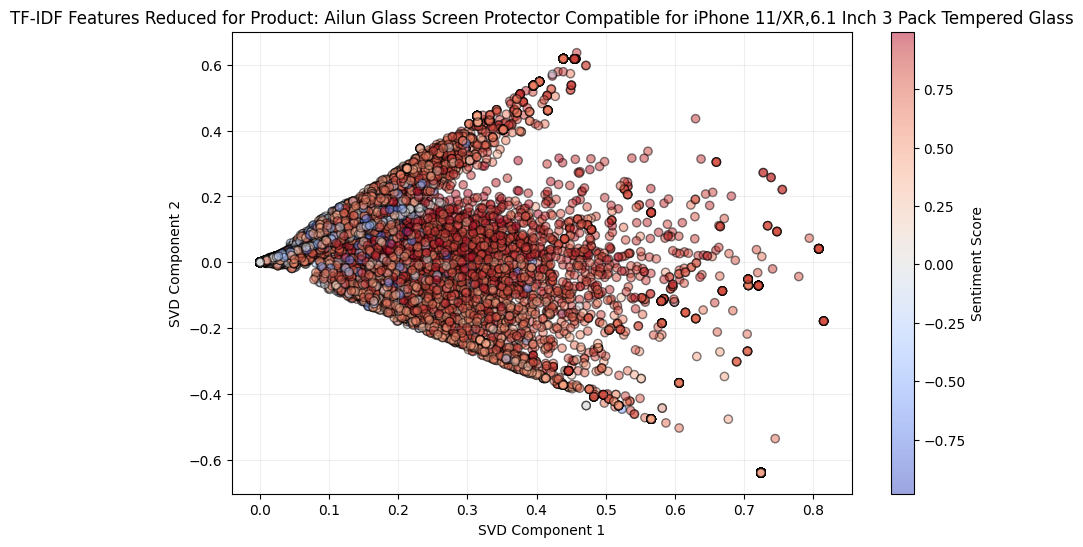

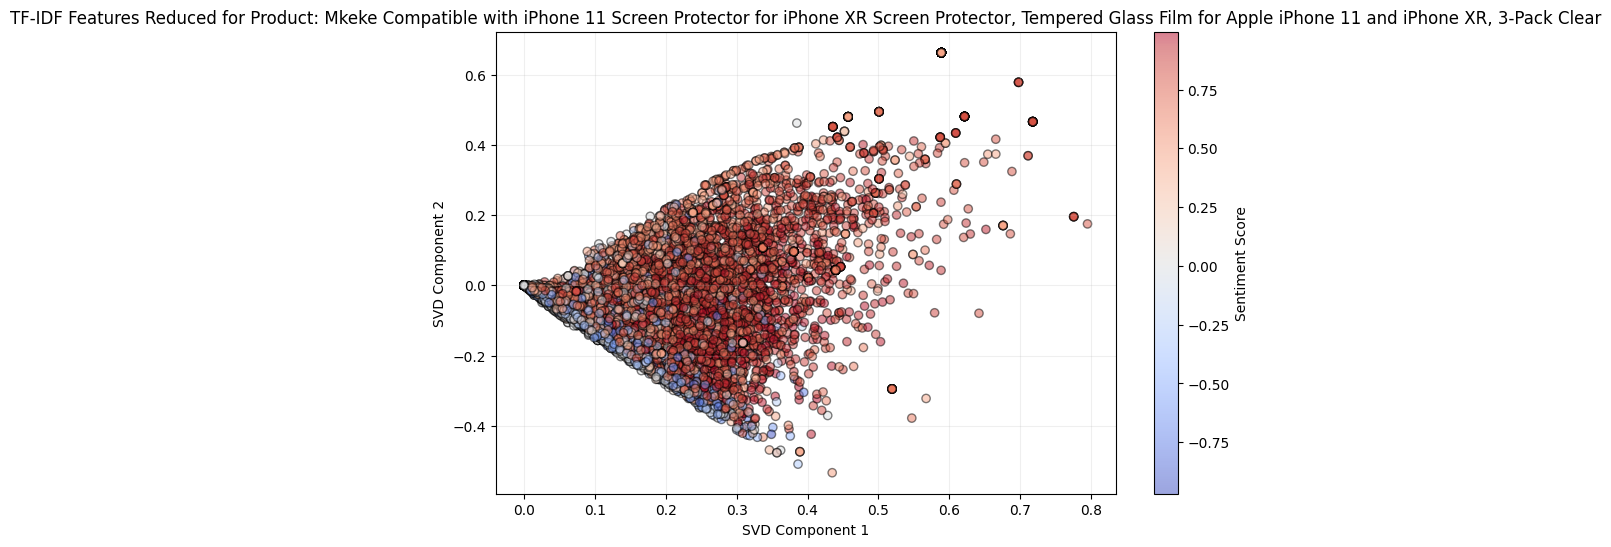

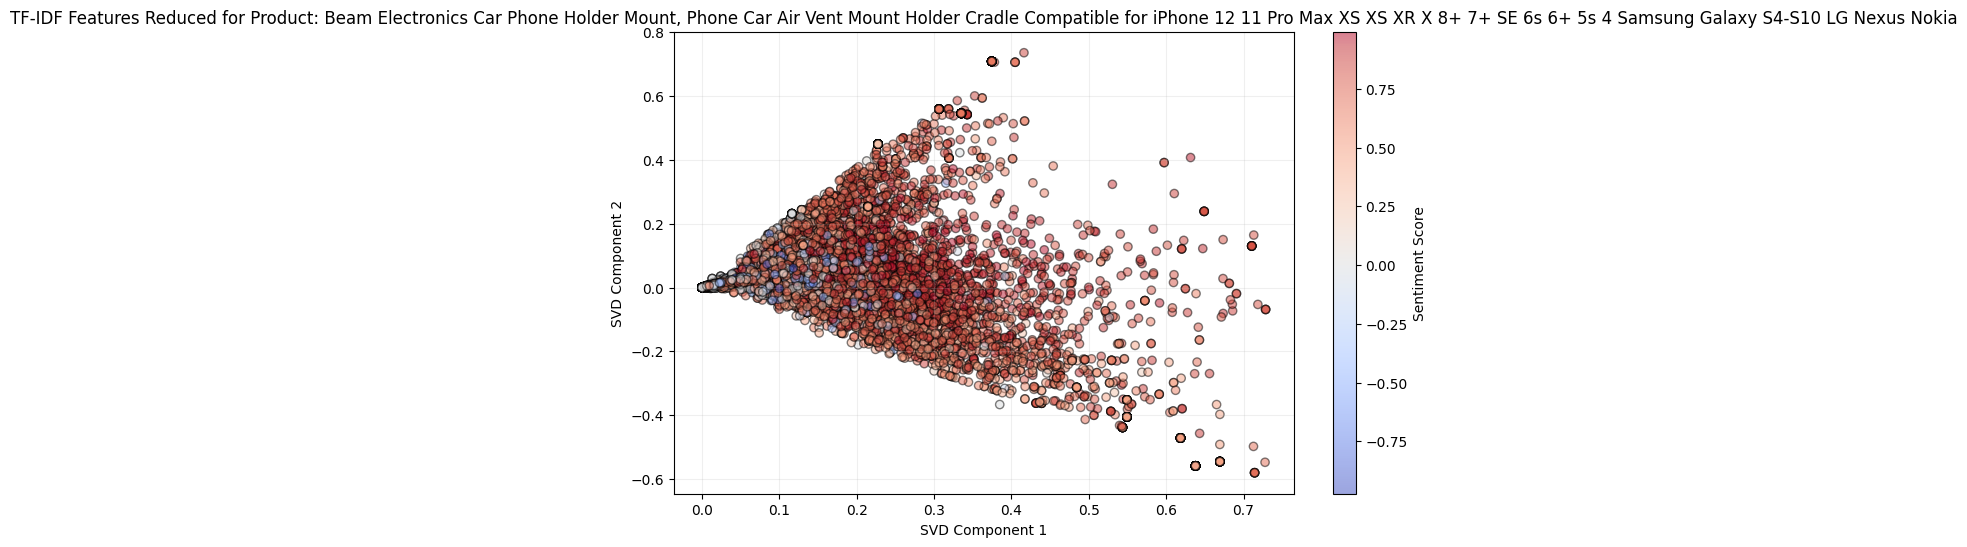

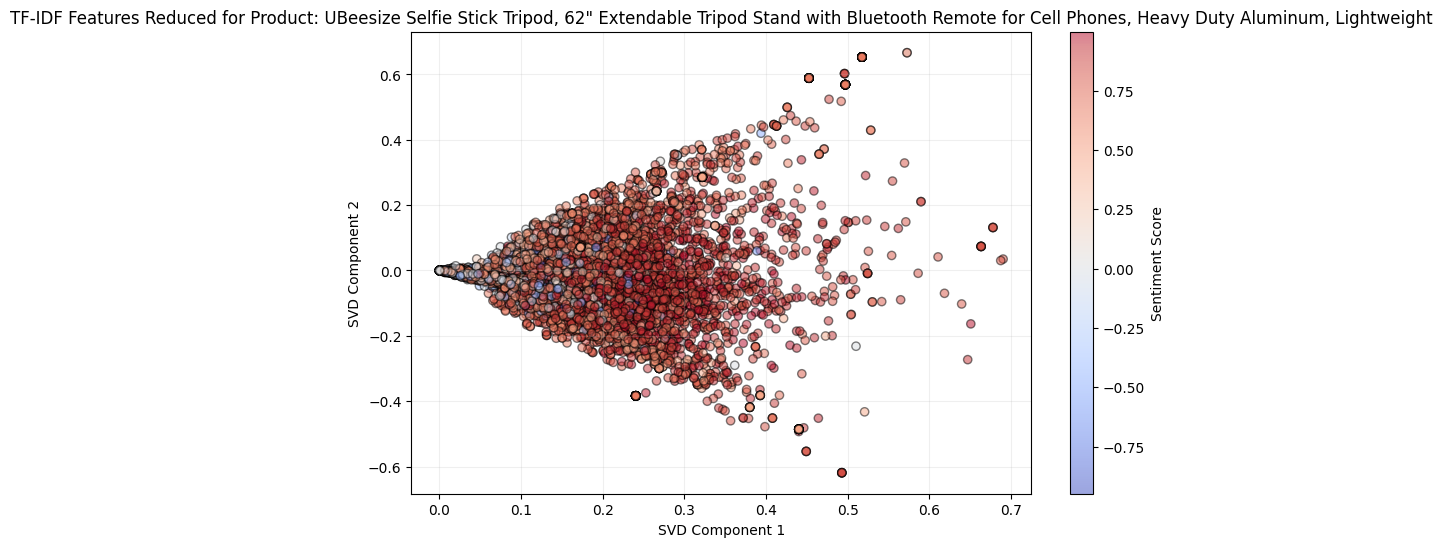

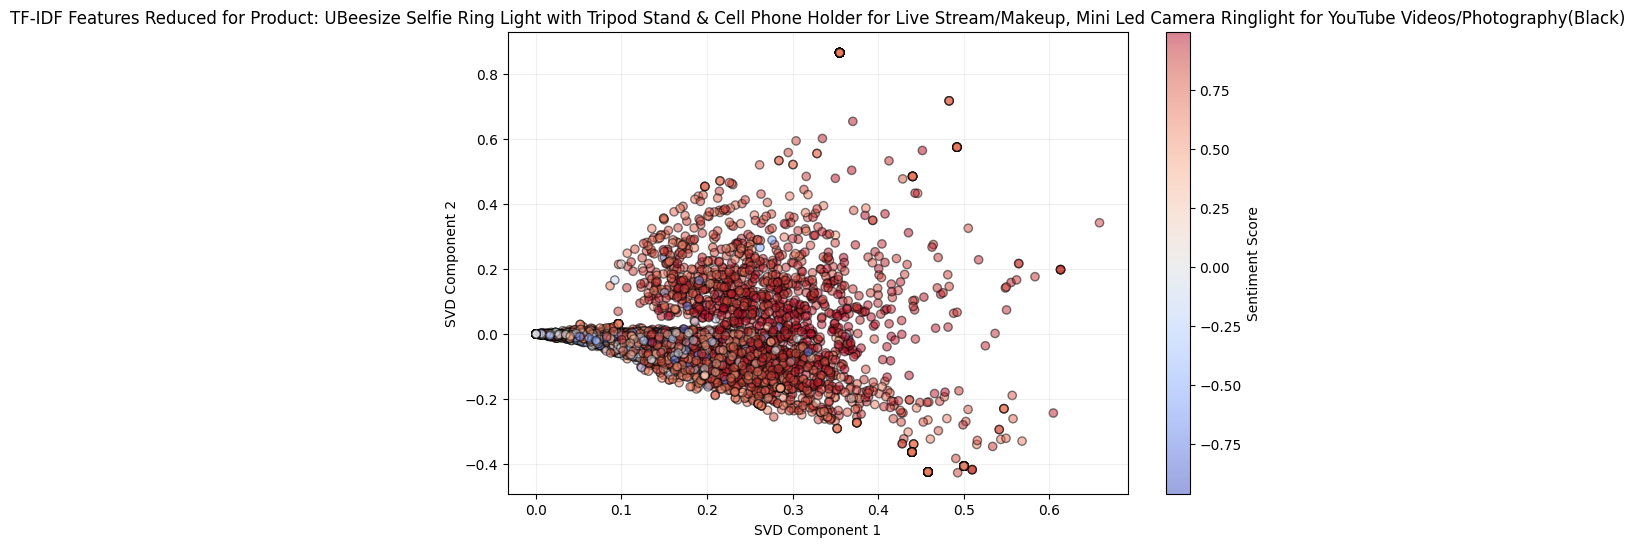

In [13]:
from sklearn.decomposition import TruncatedSVD

# Get unique products
products = merged_data['parent_asin'].unique()

# Function to perform TF-IDF and dimensionality reduction for a single product
def analyze_product_features(product_asin):
    product_reviews = merged_data[merged_data['parent_asin'] == product_asin]
    
    # Check if there are sufficient reviews
    if product_reviews.shape[0] < 2:
        print(f"Not enough reviews for product {product_asin}")
        return
    
    # TF-IDF feature extraction
    tfidf_matrix = vectorizer.fit_transform(product_reviews['text'].fillna(""))
    
    # Dimensionality Reduction with TruncatedSVD
    svd = TruncatedSVD(n_components=2, random_state=42)
    reduced_tfidf = svd.fit_transform(tfidf_matrix)
    
    # Scatter Plot
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(
        reduced_tfidf[:, 0], reduced_tfidf[:, 1],
        c=product_reviews['sentiment_score'], cmap='coolwarm', alpha=0.5, edgecolors='k'
    )
    plt.colorbar(scatter, label='Sentiment Score')
    product_title = metadata.loc[metadata['parent_asin'] == product_asin, 'title'].values[0] if not metadata.empty else product_asin
    plt.title(f'TF-IDF Features Reduced for Product: {product_title}')
    plt.xlabel('SVD Component 1')
    plt.ylabel('SVD Component 2')
    plt.grid(alpha=0.2)
    plt.show()

# Example: Analyze top 5 products with most reviews
top_products = merged_data['parent_asin'].value_counts().head(5).index

for product_asin in top_products:
    analyze_product_features(product_asin)

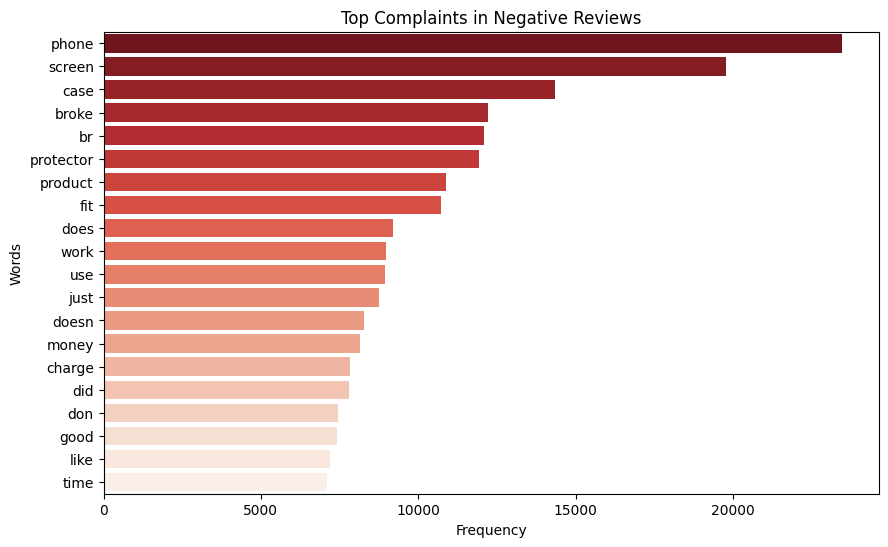

In [14]:
# Insights for Product Improvement
negative_feedback = merged_data[merged_data['sentiment_category'] == 'Negative']

# Analyze most common complaints
negative_tfidf = vectorizer.fit_transform(negative_feedback['text'].fillna(""))
negative_words = vectorizer.get_feature_names_out()
negative_scores = np.array(negative_tfidf.sum(axis=0)).flatten()
negative_word_freq = pd.DataFrame({'word': negative_words, 'frequency': negative_scores})
negative_word_freq = negative_word_freq.sort_values(by='frequency', ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(data=negative_word_freq, x='frequency', y='word', palette='Reds_r')
plt.title('Top Complaints in Negative Reviews')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\opinion_lexicon.zip.


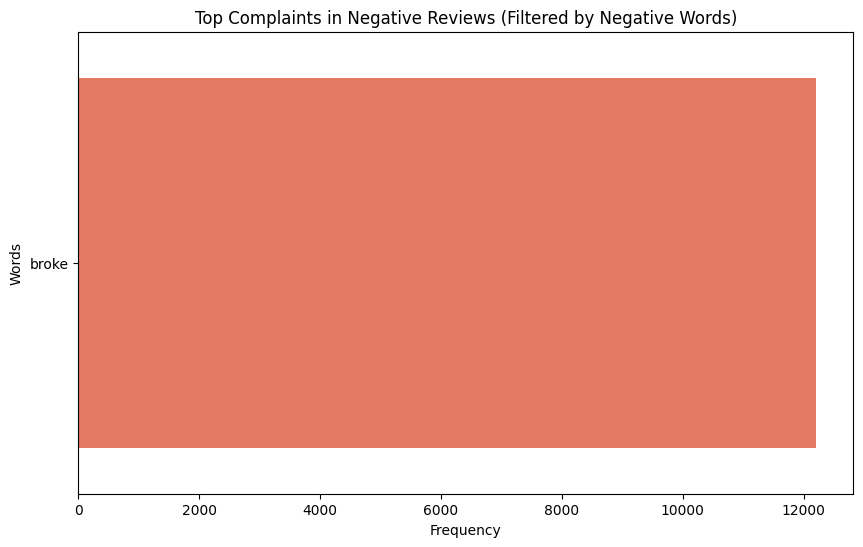

In [15]:
from nltk.corpus import opinion_lexicon
from nltk import download

# Download the opinion lexicon
download('opinion_lexicon')

# Get a list of negative words from the lexicon
negative_words_set = set(opinion_lexicon.negative())

# Filter TF-IDF words to include only those with negative meanings
negative_word_freq_filtered = negative_word_freq[negative_word_freq['word'].isin(negative_words_set)]

# Plot the top complaints with negative meanings
plt.figure(figsize=(10, 6))
sns.barplot(data=negative_word_freq_filtered.sort_values(by='frequency', ascending=False).head(20),
            x='frequency', y='word', palette='Reds_r')
plt.title('Top Complaints in Negative Reviews (Filtered by Negative Words)')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()
